In [6]:
pip install torch-choice

In [7]:
from time import time
import pandas as pd
import torch

from torch_choice.data import ChoiceDataset, utils
from torch_choice.model import ConditionalLogitModel

from torch_choice import run

In [8]:
if torch.cuda.is_available():
    print(f'CUDA device used: {torch.cuda.get_device_name()}')
    device = 'cuda'
else:
    print('Running tutorial on CPU.')
    device = 'cpu'

CUDA device used: Tesla T4


In [10]:
df = pd.read_csv('ModeCanada.csv')
df = df.query('noalt == 4').reset_index(drop=True)
df.sort_values(by='case', inplace=True)
df.head()

,Unnamed: 0,case,alt,choice,dist,cost,ivt,ovt,freq,income,urban,noalt
0,304,109,train,0,377,58.25,215,74,4,45,0,4
1,305,109,air,1,377,142.80,56,85,9,45,0,4
2,306,109,bus,0,377,27.52,301,63,8,45,0,4
3,307,109,car,0,377,71.63,262,0,0,45,0,4
4,308,110,train,0,377,58.25,215,74,4,70,0,4


In [11]:
df.shape

(11116, 12)

In [12]:
item_index = df[df['choice'] == 1].sort_values(by='case')['alt'].reset_index(drop=True)
print(item_index)

0       air
1       air
2       air
3       air
4       air
       ... 
2774    car
2775    car
2776    car
2777    car
2778    car
Name: alt, Length: 2779, dtype: object


In [13]:
item_names = ['air', 'bus', 'car', 'train']
num_items = 4
encoder = dict(zip(item_names, range(num_items)))
print(f"{encoder=:}")
item_index = item_index.map(lambda x: encoder[x])
item_index = torch.LongTensor(item_index)
print(f"{item_index=:}")

encoder={'air': 0, 'bus': 1, 'car': 2, 'train': 3}
item_index=tensor([0, 0, 0,  ..., 2, 2, 2])


In [14]:
price_cost_freq_ovt = utils.pivot3d(df, dim0='case', dim1='alt',
                                    values=['cost', 'freq', 'ovt'])
print(f'{price_cost_freq_ovt.shape=:}')

price_ivt = utils.pivot3d(df, dim0='case', dim1='alt', values='ivt')
print(f'{price_ivt.shape=:}')

price_cost_freq_ovt.shape=torch.Size([2779, 4, 3])
price_ivt.shape=torch.Size([2779, 4, 1])


In [15]:
session_income = df.groupby('case')['income'].first()
session_income = torch.Tensor(session_income.values).view(-1, 1)
print(f'{session_income.shape=:}')

session_income.shape=torch.Size([2779, 1])


In [16]:
dataset = ChoiceDataset(item_index=item_index,
                        price_cost_freq_ovt=price_cost_freq_ovt,
                        session_income=session_income,
                        price_ivt=price_ivt
                        ).to(device)

No `session_index` is provided, assume each choice instance is in its own session.


In [17]:
print(dataset)

ChoiceDataset(num_items=4, num_users=1, num_sessions=2779, label=[], item_index=[2779], user_index=[], session_index=[2779], item_availability=[], price_cost_freq_ovt=[2779, 4, 3], session_income=[2779, 1], price_ivt=[2779, 4, 1], device=cuda:0)


/usr/local/lib/python3.10/dist-packages/torch_choice/data/choice_dataset.py:240: UserWarning: The number of items is inferred from the number of unique items, excluding -1's denoting outside options, in the item_index tensor. This might lead to unexpected behaviors if some items never appeared in the item_index tensor. For a safer behavior, please provide the number of items explicitly by using the num_items keyword while initializing the ChoiceDataset class.
  warnings.warn(f"The number of items is inferred from the number of unique items, excluding -1's denoting outside options, in the item_index tensor. This might lead to unexpected behaviors if some items never appeared in the item_index tensor. For a safer behavior, please provide the number of items explicitly by using the num_items keyword while initializing the ChoiceDataset class.")
/usr/local/lib/python3.10/dist-packages/torch_choice/data/choice_dataset.py:260: UserWarning: The number of sessions is inferred from the number o

In [18]:
model = ConditionalLogitModel(coef_variation_dict={'price_cost_freq_ovt': 'constant',
                                                   'session_income': 'item',
                                                   'price_ivt': 'item-full',
                                                   'intercept': 'item'},
                              num_param_dict={'price_cost_freq_ovt': 3,
                                              'session_income': 1,
                                              'price_ivt': 1,
                                              'intercept': 1},
                              num_items=4)

In [19]:
model = model.to(device)

In [20]:
model = model = ConditionalLogitModel(
    formula='(price_cost_freq_ovt|constant) + (session_income|item) + (price_ivt|item-full) + (intercept|item)',
    dataset=dataset,
    num_items=4)

In [21]:
print(model)

ConditionalLogitModel(
  (coef_dict): ModuleDict(
    (price_cost_freq_ovt[constant]): Coefficient(variation=constant, num_items=4, num_users=None, num_params=3, 3 trainable parameters in total, initialization=normal, device=cpu).
    (session_income[item]): Coefficient(variation=item, num_items=4, num_users=None, num_params=1, 3 trainable parameters in total, initialization=normal, device=cpu).
    (price_ivt[item-full]): Coefficient(variation=item-full, num_items=4, num_users=None, num_params=1, 4 trainable parameters in total, initialization=normal, device=cpu).
    (intercept[item]): Coefficient(variation=item, num_items=4, num_users=None, num_params=1, 3 trainable parameters in total, initialization=normal, device=cpu).
  )
)
Conditional logistic discrete choice model, expects input features:

X[price_cost_freq_ovt[constant]] with 3 parameters, with constant level variation.
X[session_income[item]] with 1 parameters, with item level variation.
X[price_ivt[item-full]] with 1 parame

In [22]:
start_time = time()
run(model, dataset, num_epochs=500, learning_rate=0.01, model_optimizer="LBFGS", batch_size=-1)
print('Time taken:', time() - start_time)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


==================== model received ====================
ConditionalLogitModel(
  (coef_dict): ModuleDict(
    (price_cost_freq_ovt[constant]): Coefficient(variation=constant, num_items=4, num_users=None, num_params=3, 3 trainable parameters in total, initialization=normal, device=cpu).
    (session_income[item]): Coefficient(variation=item, num_items=4, num_users=None, num_params=1, 3 trainable parameters in total, initialization=normal, device=cpu).
    (price_ivt[item-full]): Coefficient(variation=item-full, num_items=4, num_users=None, num_params=1, 4 trainable parameters in total, initialization=normal, device=cpu).
    (intercept[item]): Coefficient(variation=item, num_items=4, num_users=None, num_params=1, 3 trainable parameters in total, initialization=normal, device=cpu).
  )
)
Conditional logistic discrete choice model, expects input features:

X[price_cost_freq_ovt[constant]] with 3 parameters, with constant level variation.
X[session_income[item]] with 1 parameters, with it

INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                  | Params | Mode 
--------------------------------------------------------
0 | model | ConditionalLogitModel | 13     | train
--------------------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Time taken for training: 35.385313272476196
Skip testing, no test dataset is provided.
==================== model results ====================
Log-likelihood: [Training] -1874.3426513671875, [Validation] N/A, [Test] N/A

| Coefficient                     |   Estimation |   Std. Err. |   z-value |    Pr(>|z|) | Significance   |
|:--------------------------------|-------------:|------------:|----------:|------------:|:---------------|
| price_cost_freq_ovt[constant]_0 |  -0.0333389  |  0.00709541 |  -4.69866 | 2.61876e-06 | ***            |
| price_cost_freq_ovt[constant]_1 |   0.0925298  |  0.00509756 |  18.1518  | 0           | ***            |
| price_cost_freq_ovt[constant]_2 |  -0.0430032  |  0.00322472 | -13.3355  | 0           | ***            |
| session_income[item]_0          |  -0.0890841  |  0.018347   |  -4.85551 | 1.20076e-06 | ***            |
| session_income[item]_1          |  -0.0279933  |  0.00387255 |  -7.22864 | 4.87832e-13 | ***            |
| session_income[item]_

/usr/local/lib/python3.10/dist-packages/torch_choice/data/choice_dataset.py:240: UserWarning: The number of items is inferred from the number of unique items, excluding -1's denoting outside options, in the item_index tensor. This might lead to unexpected behaviors if some items never appeared in the item_index tensor. For a safer behavior, please provide the number of items explicitly by using the num_items keyword while initializing the ChoiceDataset class.
  warnings.warn(f"The number of items is inferred from the number of unique items, excluding -1's denoting outside options, in the item_index tensor. This might lead to unexpected behaviors if some items never appeared in the item_index tensor. For a safer behavior, please provide the number of items explicitly by using the num_items keyword while initializing the ChoiceDataset class.")


In [23]:
model.get_coefficient('intercept[item]').shape

torch.Size([3, 1])

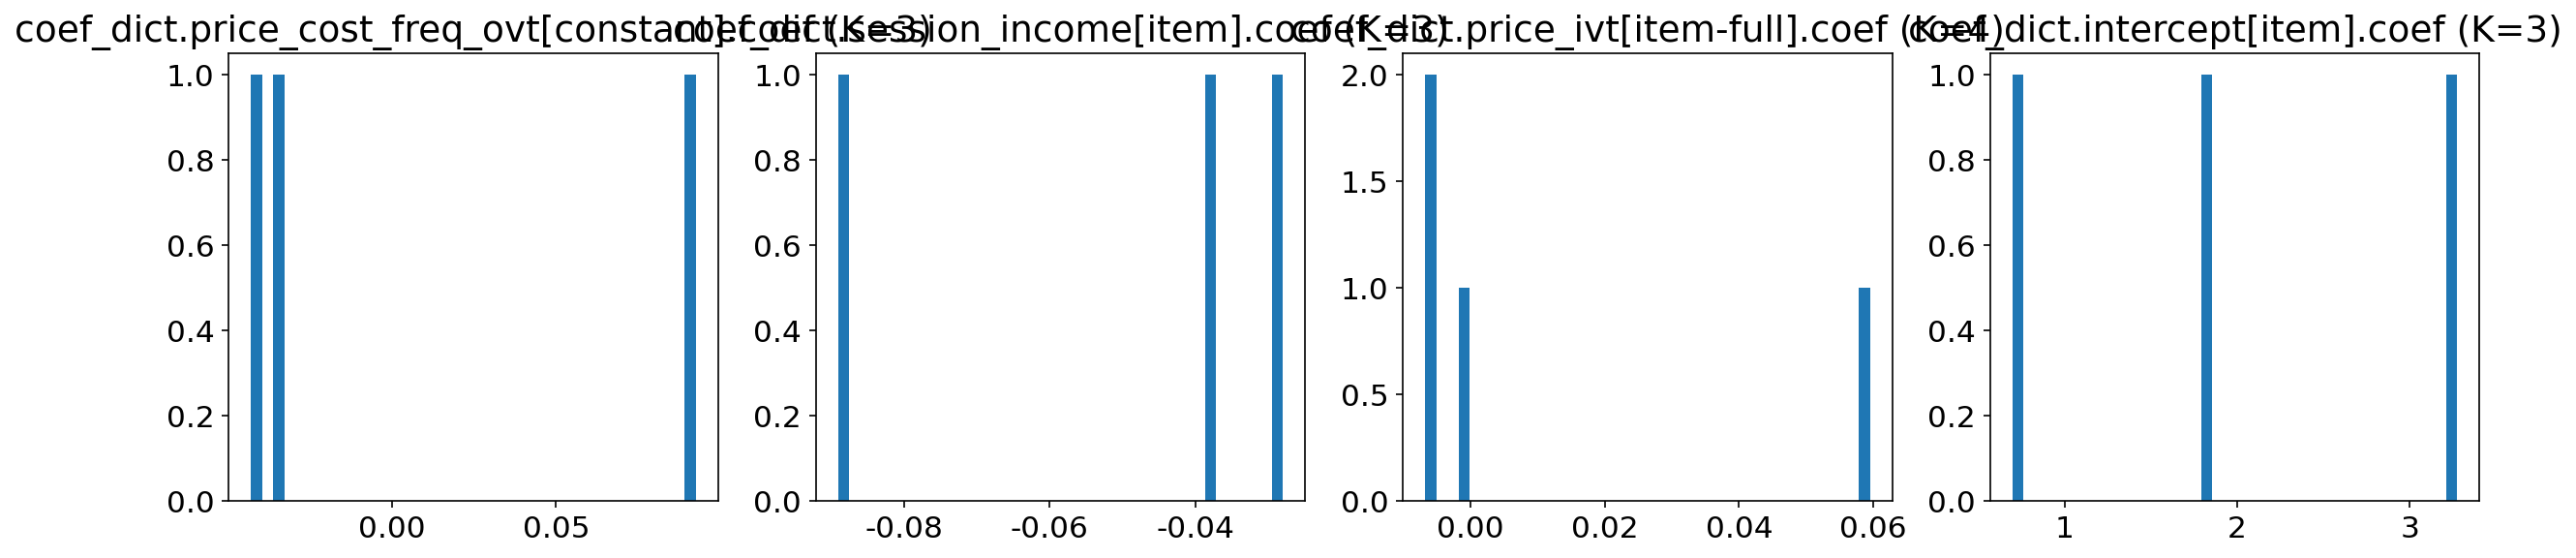

In [24]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['axes.unicode_minus'] = False
def plot_model_initial_coefficients(model_to_plot: torch.nn.Module) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4), dpi=150)

    for i, (coef_name, coef_value) in enumerate(model_to_plot.state_dict().items()):
        arr = coef_value.view(-1,).to("cpu").numpy()
        axes[i].hist(arr, bins=40)
        axes[i].set_title(f"{coef_name} (K={len(arr)})")
plot_model_initial_coefficients(model)

In [25]:
import random
import numpy as np
import torch

SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)